# ⌚️ Inferring Relationships in Wearable-Sourced Health Data

Ths notebook explores, models and attempts to explain latent patterns in data sourced from my Apple Watch. 

❗️ TODO UPDATE THIS LINK TO POINT TO MY COLAB NOTEBOOK

[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/AIPI-590-XAI/Duke-AI-XAI/blob/dev/explainable-ml-example-notebooks/local_explanations.ipynb)

In [1]:
import os 
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm import tqdm 

## Data

Define an extraction step to ingest the raw data, which we'll skil if the post-processed data is available to avoid oversharing PII.

### Extraction 

Apple stores health data in a proprietary XML format which can be exported in bulk. 

Note: Parsing the HealthKit format below is done with the 

We'll limit the temporal analysis required here by summing within a calendar day. This will yield some reasonable and intuitve metrics we can try to predict off of. The consolidation of the relevant tables is surprisingly straightforward once we apply this constraint: 

HKCategoryTypeIdentifierSleepAnalysis
- on end_date got range hours of sleep 

HKQuantityTypeIdentifierActiveEnergyBurned
- on end_date burned value calories
- sum value by date

HKQuantityTypeIdentifierAppleExerciseTime
- on end_date exercised for 1 min
- sum value by end_date

HKQuantityTypeIdentifierAppleStandTime
- on end_date stood for value mins
- sum value on end_date

HKQuantityTypeIdentifierBasalEnergyBurned
- on end_date calories burned on end_date
- sum value on end_date

HKQuantityTypeIdentifierFlightsClimbed
- on end_date 1 flight climbed 
- sum value on end_date

HKQuantityTypeIdentifierHeartRate
- instantaneous HR measurements at end_date
- perhaps take max value of columnd within date

HKQuantityTypeIdentifierOxygenSaturation
- instantaneous on end date
- take max and min for the day

HKQuantityTypeIdentifierPhysicalEffort
- instanteous measure of energy on end_date
- take max and min for the day 

HKQuantityTypeIdentifierRespiratoryRate
- instantaneous 
- take average? 

HKQuantityTypeIdentifierRestingHeartRate
- value has an average over a short period (length of end_date - start_date)
- take min and max for the day 

HKQuantityTypeIdentifierStepCount
- value for short window 
- sum for end_date

HKQuantityTypeIdentifierTimeInDaylight
- sum value for end_date

In [2]:
INCLUDE_FLAGS = (
    "HKCategoryTypeIdentifierSleepAnalysis",
    "HKQuantityTypeIdentifierActiveEnergyBurned",
    "HKQuantityTypeIdentifierAppleExerciseTime",
    "HKQuantityTypeIdentifierAppleStandTime",
    "HKQuantityTypeIdentifierBasalEnergyBurned",
    "HKQuantityTypeIdentifierFlightsClimbed",
    "HKQuantityTypeIdentifierHeartRate",
    "HKQuantityTypeIdentifierOxygenSaturation",
    "HKQuantityTypeIdentifierPhysicalEffort",
    "HKQuantityTypeIdentifierRespiratoryRate",
    "HKQuantityTypeIdentifierRestingHeartRate",
    "HKQuantityTypeIdentifierStepCount",
    "HKQuantityTypeIdentifierTimeInDaylight",
)

❗️ The library we use for parsing HealthKit data reliese on some enum behavior that wasn't stabilized in python 3.11, however Colab is still running on 3.11 so we can't upgrade. Below GPT-5-supplied workaround to patch enum behavior is necessary if a full parsing operation is run (shoudn't be necessary if running on colab though)

In [3]:
import sys, enum, threading
if (3, 11) <= sys.version_info < (3, 12):
    _old_contains = enum.EnumMeta.__contains__
    _guard = threading.local(); _guard.active = False

    def _patched_contains(cls, member):
        # avoid recursive re-entry
        if getattr(_guard, "active", False):
            # Fall back to equality semantics—do NOT recurse
            try:
                return any(member == m or str(member) == m.value for m in cls)  # best-effort
            except Exception:
                return False
        try:
            return _old_contains(cls, member)
        except TypeError:
            try:
                _guard.active = True
                # emulate 3.12: try coercion; True if coercible, else False
                cls(member)  # may raise ValueError
                return True
            except Exception:
                return False
            finally:
                _guard.active = False

    enum.EnumMeta.__contains__ = _patched_contains


Abstract the XML-based format and emit a dict of dataframes for each of our target tables. 

In [4]:
from apple_health_parser.utils.parser import Parser

def parse_healthkit_data(path, output_dir="./data/out", flags=INCLUDE_FLAGS): 
    """
    Go through the raw data with the help of the above import. 

    NOTE: HealthKit parsing logic courtesy of GPT-5, see https://chatgpt.com/share/68d811d3-6e00-8013-bca7-e39aa6e6f106
    """
    parser = Parser(export_file=path, output_dir=output_dir, overwrite=True)

    flags = [f for f in parser.flags if f.startswith(flags)]

    dfs = {}      # dict[str, pd.DataFrame]  -> all parsed flags you can model from
    errors = {}   # keep going even if a flag fails

    for f in tqdm(flags):
        try:
            parsed = parser.get_flag_records(flag=f)   # returns ParsedData
            if not parsed.records.empty:
                dfs[f] = parsed.records
        except Exception as e:
            errors[f] = repr(e)

    print(f"Extracted {len(dfs)} tables with {len(errors)} errors")

    return dfs

In [5]:
def aggregate_by_date(df, date_col, val_col, op="sum", name=None):
    """
    Aggregate dataframe column by date, summing

    NOTE:  Date aggregation syntax courtesy of gpt-5, see https://chatgpt.com/share/68d82165-543c-8013-a1c4-4d5ac9d68410
    """
    groups = df.groupby(df[date_col].dt.date)
        
    agg_df = None
    match(op):         
        case "min" : 
            agg_df = groups[val_col].min().reset_index()
        case "max" : 
            agg_df = groups[val_col].max().reset_index()
        case "mean" : 
            agg_df = groups[val_col].mean().reset_index()
        case "sum" | None | _ : 
            agg_df = groups[val_col].sum().reset_index()

    kwargs = { 'columns': [name] } if name else {}
    return pd.DataFrame(agg_df[val_col].values, index=agg_df[date_col].values, **kwargs)

In [ ]:
def process_healthkit_data(table_dfs):
    """
    Given a dict of dataframes with our target data container, filter and construct a unifed dataframe 
    that aggregates data by date. Note the tight coupling with parse flags above. 
    """

    agg_dfs = {}
    
    # Sleep categories need to be filtered, but otherwise we should be fine without (filtering rows) based on samples inspected
    sleep = table_dfs['HKCategoryTypeIdentifierSleepAnalysis']
    condition = (sleep.value != "HKCategoryValueSleepAnalysisInBed") & (sleep.value != "HKCategoryValueSleepAnalysisAwake")
    agg_dfs['sleep'] = aggregate_by_date(sleep[condition], date_col="end_date", val_col="range", op="sum", name="sleep_h") 

    agg_dfs['energy'] = aggregate_by_date(table_dfs['HKQuantityTypeIdentifierActiveEnergyBurned'], date_col="end_date", val_col="value", op="sum", name="active_cal") 
    agg_dfs['exercise'] = aggregate_by_date(table_dfs['HKQuantityTypeIdentifierAppleExerciseTime'], date_col="end_date", val_col="value", op="sum", name="exercise_m") 
    agg_dfs['stand'] = aggregate_by_date(table_dfs['HKQuantityTypeIdentifierAppleStandTime'], date_col="end_date", val_col="value", op="sum", name="stand_m") 
    agg_dfs['basal'] = aggregate_by_date(table_dfs['HKQuantityTypeIdentifierBasalEnergyBurned'], date_col="end_date", val_col="value", op="sum", name="basal_cal") 
    agg_dfs['flights'] = aggregate_by_date(table_dfs['HKQuantityTypeIdentifierFlightsClimbed'], date_col="end_date", val_col="value", op="sum", name="flights") 
    agg_dfs['hr'] = aggregate_by_date(table_dfs['HKQuantityTypeIdentifierHeartRate'], date_col="end_date", val_col="value", op="max", name="max_hr") 
    agg_dfs['o2'] = aggregate_by_date(table_dfs['HKQuantityTypeIdentifierOxygenSaturation'], date_col="end_date", val_col="value", op="min", name="min_o2") 
    agg_dfs['effort'] = aggregate_by_date(table_dfs['HKQuantityTypeIdentifierPhysicalEffort'], date_col="end_date", val_col="value", op="sum", name="activity_mets") 
    agg_dfs['rr'] = aggregate_by_date(table_dfs['HKQuantityTypeIdentifierRespiratoryRate'], date_col="end_date", val_col="value", op="mean", name="avg_rr") 
    agg_dfs['resting'] = aggregate_by_date(table_dfs['HKQuantityTypeIdentifierRestingHeartRate'], date_col="end_date", val_col="value", op="mean", name="avg_resting_hr") 
    agg_dfs['step'] = aggregate_by_date(table_dfs['HKQuantityTypeIdentifierStepCount'], date_col="end_date", val_col="value", op="sum", name="steps") 
    agg_dfs['daylight'] = aggregate_by_date(table_dfs['HKQuantityTypeIdentifierTimeInDaylight'], date_col="end_date", val_col="value", op="sum", name="daylight_h") 

    # Migrate to float value for sleep duration from timedelta.  NOTE: GPT-5-supplied float conversion
    agg_dfs['sleep'].sleep_h = agg_dfs['sleep'].sleep_h / np.timedelta64(1, "h")

    # Join our table DFs
    df = pd.DataFrame()
    df = df.join(list(agg_dfs.values()), how="outer")
    #macro_df.reset_index(names='date', inplace=True)

    # Coax the string value for the date back to a numeric and sort. NOTE: type conversion courtesy of GPT-5
    df.index = pd.to_datetime(df.index, errors="coerce")
    df.sort_index(inplace=True)

    return df

If we can restore the processed data, do so, otherwise mine our data out of the full HealthKit export.

In [ ]:
raw_dataset = "./data/export.zip"
processed_dataset = "./data/health.csv"

df = None
if os.path.exists(processed_dataset):
    df = pd.read_csv(processed_dataset)
else:         
    table_dfs = parse_healthkit_data(raw_dataset)
    df = process_healthkit_data(table_dfs)
    
    df.to_csv(processed_dataset)

In [76]:
### 
table_dfs

{'HKCategoryTypeIdentifierSleepAnalysis':                                         type          source_name  \
 0      HKCategoryTypeIdentifierSleepAnalysis                Clock   
 1      HKCategoryTypeIdentifierSleepAnalysis                Clock   
 2      HKCategoryTypeIdentifierSleepAnalysis                Clock   
 3      HKCategoryTypeIdentifierSleepAnalysis                Clock   
 4      HKCategoryTypeIdentifierSleepAnalysis                Clock   
 ...                                      ...                  ...   
 33468  HKCategoryTypeIdentifierSleepAnalysis  Jason’s Apple Watch   
 33469  HKCategoryTypeIdentifierSleepAnalysis  Jason’s Apple Watch   
 33470  HKCategoryTypeIdentifierSleepAnalysis  Jason’s Apple Watch   
 33471  HKCategoryTypeIdentifierSleepAnalysis  Jason’s Apple Watch   
 33472  HKCategoryTypeIdentifierSleepAnalysis  Jason’s Apple Watch   
 
       source_version  unit             creation_date  \
 0                 50  None 2018-06-20 06:17:12-04:00   
 1 

In [77]:

agg_dfs = {}

# Sleep categories need to be filtered, but otherwise we should be fine without (filtering rows) based on samples inspected
sleep = table_dfs['HKCategoryTypeIdentifierSleepAnalysis']
condition = (sleep.value != "HKCategoryValueSleepAnalysisInBed") & (sleep.value != "HKCategoryValueSleepAnalysisAwake")
agg_dfs['sleep'] = aggregate_by_date(sleep[condition], date_col="end_date", val_col="range", op="sum", name="sleep_h") 

agg_dfs['energy'] = aggregate_by_date(table_dfs['HKQuantityTypeIdentifierActiveEnergyBurned'], date_col="end_date", val_col="value", op="sum", name="active_cal") 
agg_dfs['exercise'] = aggregate_by_date(table_dfs['HKQuantityTypeIdentifierAppleExerciseTime'], date_col="end_date", val_col="value", op="sum", name="exercise_m") 
agg_dfs['stand'] = aggregate_by_date(table_dfs['HKQuantityTypeIdentifierAppleStandTime'], date_col="end_date", val_col="value", op="sum", name="stand_m") 
agg_dfs['basal'] = aggregate_by_date(table_dfs['HKQuantityTypeIdentifierBasalEnergyBurned'], date_col="end_date", val_col="value", op="sum", name="basal_cal") 
agg_dfs['flights'] = aggregate_by_date(table_dfs['HKQuantityTypeIdentifierFlightsClimbed'], date_col="end_date", val_col="value", op="sum", name="flights") 
agg_dfs['hr'] = aggregate_by_date(table_dfs['HKQuantityTypeIdentifierHeartRate'], date_col="end_date", val_col="value", op="max", name="max_hr") 
agg_dfs['o2'] = aggregate_by_date(table_dfs['HKQuantityTypeIdentifierOxygenSaturation'], date_col="end_date", val_col="value", op="min", name="min_o2") 
agg_dfs['effort'] = aggregate_by_date(table_dfs['HKQuantityTypeIdentifierPhysicalEffort'], date_col="end_date", val_col="value", op="sum", name="activity_mets") 
agg_dfs['rr'] = aggregate_by_date(table_dfs['HKQuantityTypeIdentifierRespiratoryRate'], date_col="end_date", val_col="value", op="mean", name="avg_rr") 
agg_dfs['resting'] = aggregate_by_date(table_dfs['HKQuantityTypeIdentifierRestingHeartRate'], date_col="end_date", val_col="value", op="mean", name="avg_resting_hr") 
agg_dfs['step'] = aggregate_by_date(table_dfs['HKQuantityTypeIdentifierStepCount'], date_col="end_date", val_col="value", op="sum", name="steps") 
agg_dfs['daylight'] = aggregate_by_date(table_dfs['HKQuantityTypeIdentifierTimeInDaylight'], date_col="end_date", val_col="value", op="sum", name="daylight_h") 

# Migrate to float value for sleep duration from timedelta.  NOTE: GPT-5-supplied float conversion
agg_dfs['sleep'].sleep_h = agg_dfs['sleep'].sleep_h / np.timedelta64(1, "h")

In [ ]:
agg_dfs

In [79]:
# Join our table DFs
df = pd.DataFrame()
df = df.join(list(agg_dfs.values()), how="outer")
#macro_df.reset_index(names='date', inplace=True)

# Coax the string value for the date back to a numeric and sort. NOTE: type conversion courtesy of GPT-5
df.index = pd.to_datetime(df.index, errors="coerce")
df.sort_index(inplace=True)

In [80]:
df

,sleep_h,active_cal,exercise_m,stand_m,basal_cal,flights,max_hr,min_o2,activity_mets,avg_rr,avg_resting_hr,steps,daylight_h
2018-04-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,76.0,NaN
2018-04-04,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,4615.0,NaN
2018-04-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2996.0,NaN
2018-04-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.0,NaN
2018-04-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,594.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-09-23,6.024722,504.973,11.0,122.0,1943.365,8.0,100.0,0.94,1541.9,12.441860,50.0,7830.0,42.0
2025-09-24,6.993056,490.431,21.0,95.0,1891.894,19.0,129.0,0.92,1455.4,11.918605,54.0,8274.0,53.0
2025-09-25,5.205556,1086.919,113.0,158.0,1976.054,9.0,163.0,0.93,2089.4,12.046875,56.0,11772.0,110.0
2025-09-26,NaN,1063.219,114.0,185.0,2036.562,41.0,145.0,0.94,2550.7,NaN,56.0,13320.0,160.0


<Axes: >

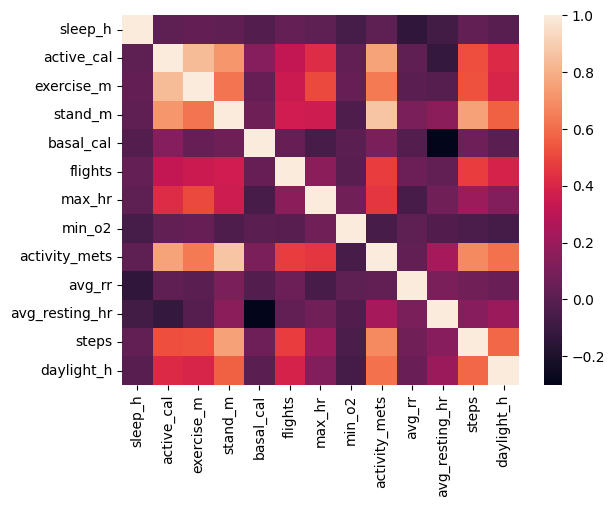

In [82]:
sns.heatmap(df.corr())

### Exploration

In [141]:
df.iloc[1590:1610]

,date,sleep_h,active_cal,exercise_h,stand_h,basal_cal,flights,max_hr,min_o2,activity_mets,avg_rr,avg_resting_hr,steps,daylight_h
1590,2022-08-11,14.538889,569.319,14.0,96.0,1990.223,14.0,104.000,0.94,NaN,13.055556,50.0,8696.0,NaN
1591,2022-08-12,13.220833,1319.638,143.0,299.0,1968.005,31.0,134.000,0.91,NaN,13.920455,55.0,29752.0,NaN
1592,2022-08-13,8.191667,1160.237,123.0,241.0,1937.588,26.0,153.000,0.97,NaN,11.500000,63.0,14056.0,NaN
1593,2022-08-14,12.567222,820.922,89.0,171.0,1996.219,22.0,103.000,0.92,NaN,13.418367,58.0,20106.0,NaN
1594,2022-08-15,16.146389,542.321,16.0,84.0,2019.003,2.0,94.000,0.92,NaN,13.058824,54.0,10468.0,NaN
1595,2022-08-16,9.566111,530.321,15.0,128.0,1934.101,7.0,163.000,0.93,NaN,12.652778,57.0,13765.0,NaN
1596,2022-08-17,5.191944,1087.901,125.0,225.0,2000.648,26.0,169.000,0.93,NaN,14.083333,56.0,26629.0,NaN
1597,2022-08-18,10.983889,436.473,4.0,73.0,1943.650,4.0,99.000,0.92,NaN,12.525641,51.0,7402.0,NaN
1598,2022-08-19,7.260556,664.594,17.0,147.0,2093.239,10.0,102.000,NaN,NaN,NaN,61.0,14067.0,NaN
1599,2022-08-20,6.467222,858.880,41.0,222.0,2032.537,22.0,140.038,0.90,NaN,13.366667,60.0,17715.0,NaN


Text(0.5, 1.0, 'Feature density for 2018-04-03 to 2025-09-27')

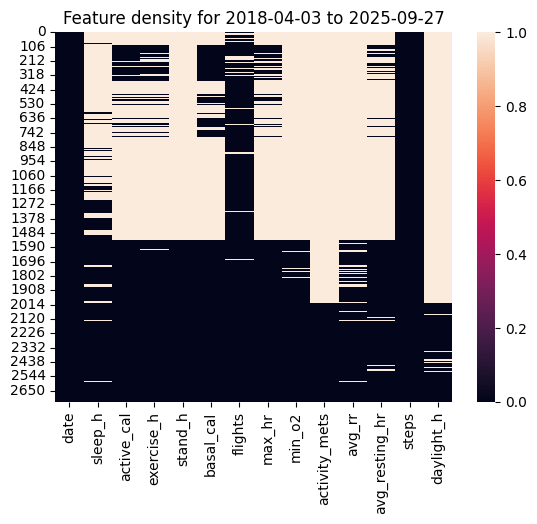

In [132]:
# Inspect for sparsity
ax = sns.heatmap(df.isna())
ax.set_title(f"Feature density for {df.iloc[0].date} to {df.iloc[-1].date}")

There's way too much sparsity in our features to attempt modeling or exploration. Slice this down to a subset that has higher fidelity. 

Text(0.5, 1.0, 'Feature density for 2023-09-26 to 2025-09-26')

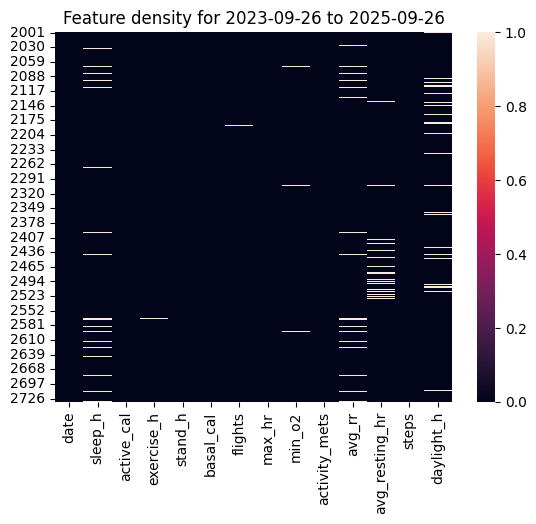

In [133]:
start_ix = df[~df.activity_mets.isna()].index[0]
df2 = df.iloc[start_ix:-1]
ax = sns.heatmap(df2.isna())
ax.set_title(f"Feature density for {df2.iloc[0].date} to {df2.iloc[-1].date}")


In [135]:
df

,date,sleep_h,active_cal,exercise_h,stand_h,basal_cal,flights,max_hr,min_o2,activity_mets,avg_rr,avg_resting_hr,steps,daylight_h
0,2018-04-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,76.0,NaN
1,2018-04-04,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,4615.0,NaN
2,2018-04-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2996.0,NaN
3,2018-04-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.0,NaN
4,2018-04-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,594.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2729,2025-09-23,6.082500,504.973,11.0,122.0,1943.365,8.0,100.0,0.94,1541.9,12.441860,50.0,7830.0,42.0
2730,2025-09-24,7.075556,490.431,21.0,95.0,1891.894,19.0,129.0,0.92,1455.4,11.918605,54.0,8274.0,53.0
2731,2025-09-25,5.238611,1086.919,113.0,158.0,1976.054,9.0,163.0,0.93,2089.4,12.046875,56.0,11772.0,110.0
2732,2025-09-26,NaN,1063.219,114.0,185.0,2036.562,41.0,145.0,0.94,2550.7,NaN,56.0,13320.0,160.0


In [134]:
df2

,date,sleep_h,active_cal,exercise_h,stand_h,basal_cal,flights,max_hr,min_o2,activity_mets,avg_rr,avg_resting_hr,steps,daylight_h
2001,2023-09-26,32.587778,529.270,13.0,113.0,1926.090,5.0,116.000,0.90,254.1,12.670455,50.0,12419.0,NaN
2002,2023-09-27,32.942500,380.001,16.0,76.0,1944.372,4.0,117.000,0.92,1114.0,12.469388,55.0,9718.0,52.0
2003,2023-09-28,31.230000,485.088,6.0,52.0,2024.562,6.0,111.000,0.94,1268.9,12.287500,56.0,5665.0,10.0
2004,2023-09-29,27.433611,477.532,15.0,108.0,1969.511,8.0,108.000,0.94,1479.0,12.657895,56.0,12215.0,78.0
2005,2023-09-30,18.075000,828.947,85.0,172.0,1859.237,4.0,125.101,0.91,2077.2,12.305085,59.0,10772.0,155.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2728,2025-09-22,5.749722,958.320,90.0,194.0,1960.212,31.0,170.000,0.91,2760.3,12.132353,56.0,13841.0,95.0
2729,2025-09-23,6.082500,504.973,11.0,122.0,1943.365,8.0,100.000,0.94,1541.9,12.441860,50.0,7830.0,42.0
2730,2025-09-24,7.075556,490.431,21.0,95.0,1891.894,19.0,129.000,0.92,1455.4,11.918605,54.0,8274.0,53.0
2731,2025-09-25,5.238611,1086.919,113.0,158.0,1976.054,9.0,163.000,0.93,2089.4,12.046875,56.0,11772.0,110.0


Because this is my health data, there are relatively few gaps, and I know, eh ... myself reasonably well, we'll impute values here using the mean for each. 

In [116]:
df2.sleep_h = df2.sleep_h.fillna(value=df2.sleep_h.mean())
df2.exercise_h = df2.sleep_h.fillna(value=df2.exercise_h.mean())
df2.flights = df2.sleep_h.fillna(value=df2.flights.mean())
df2.min_o2 = df2.sleep_h.fillna(value=df2.min_o2.mean())
df2.avg_rr = df2.sleep_h.fillna(value=df2.avg_rr.mean())
df2.avg_resting_hr = df2.sleep_h.fillna(value=df2.avg_resting_hr.mean())
df2.daylight_h = df2.sleep_h.fillna(value=df2.daylight_h.mean())

Text(0.5, 1.0, 'Feature density for 2023-09-26 to 2025-09-26')

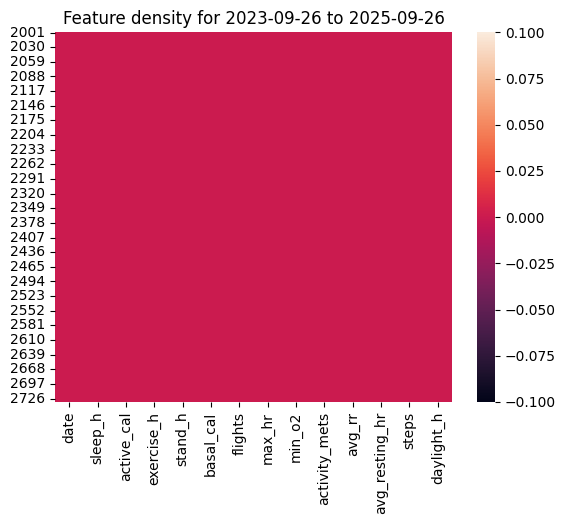

In [117]:
ax = sns.heatmap(df2.isna())
ax.set_title(f"Feature density for {df2.iloc[0].date} to {df2.iloc[-1].date}")

We now have a glorious Nan-free dataset that spans two years (exactly, wow!)

Let's do something simple but meaningful, predict how much sleep I'll get the next day. Add a target variable after dropping the last row (no target available for the last day of the dataset)

In [125]:
target = df2.sleep_h.iloc[1:].copy()

# https://stackoverflow.com/questions/26921651/how-to-delete-the-last-row-of-data-of-a-pandas-dataframe
df2.drop(df2.tail(1).index, inplace=True)

df2['sleep_h_tomorrow'] = target.to_numpy()

Next investigate any correlations between predictors (and target). 

In [127]:
def make_mask(shape): 
    """
    Make a correlation matrix mask to pass to seaborn.heatmap that hides
    redundant values in the plot. 
    """
    mask = np.zeros(shape)
    for col in range(0, shape[0]): 
        for row in range(0, shape[1]):
            if col <= row: 
                mask[col, row] = True
    return mask 

<Axes: >

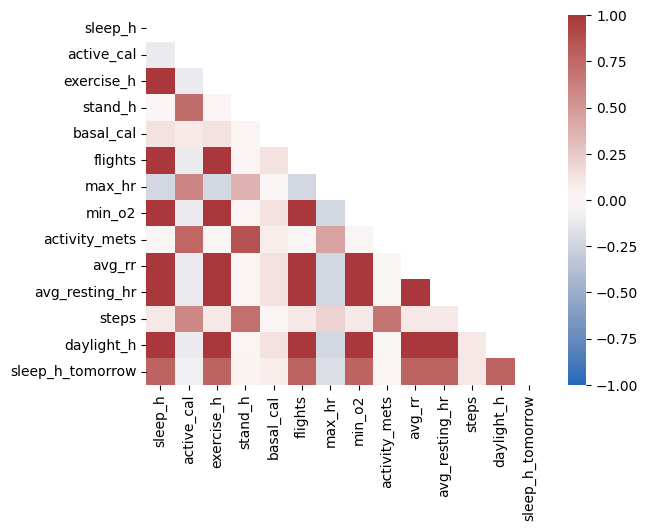

In [128]:
corr = df2.drop(["date"], axis=1).corr()
sns.heatmap(corr, vmin=-1, vmax=1, cmap="vlag", mask=make_mask(corr.shape))

In [129]:
df2

,date,sleep_h,active_cal,exercise_h,stand_h,basal_cal,flights,max_hr,min_o2,activity_mets,avg_rr,avg_resting_hr,steps,daylight_h,sleep_h_tomorrow
2001,2023-09-26,32.587778,529.270,32.587778,113.0,1926.090,32.587778,116.000,32.587778,254.1,32.587778,32.587778,12419.0,32.587778,32.942500
2002,2023-09-27,32.942500,380.001,32.942500,76.0,1944.372,32.942500,117.000,32.942500,1114.0,32.942500,32.942500,9718.0,32.942500,31.230000
2003,2023-09-28,31.230000,485.088,31.230000,52.0,2024.562,31.230000,111.000,31.230000,1268.9,31.230000,31.230000,5665.0,31.230000,27.433611
2004,2023-09-29,27.433611,477.532,27.433611,108.0,1969.511,27.433611,108.000,27.433611,1479.0,27.433611,27.433611,12215.0,27.433611,18.075000
2005,2023-09-30,18.075000,828.947,18.075000,172.0,1859.237,18.075000,125.101,18.075000,2077.2,18.075000,18.075000,10772.0,18.075000,16.066667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2727,2025-09-21,6.496389,969.809,6.496389,149.0,1974.742,6.496389,139.000,6.496389,2285.5,6.496389,6.496389,9021.0,6.496389,5.749722
2728,2025-09-22,5.749722,958.320,5.749722,194.0,1960.212,5.749722,170.000,5.749722,2760.3,5.749722,5.749722,13841.0,5.749722,6.082500
2729,2025-09-23,6.082500,504.973,6.082500,122.0,1943.365,6.082500,100.000,6.082500,1541.9,6.082500,6.082500,7830.0,6.082500,7.075556
2730,2025-09-24,7.075556,490.431,7.075556,95.0,1891.894,7.075556,129.000,7.075556,1455.4,7.075556,7.075556,8274.0,7.075556,5.238611


We have a few strong, positive correlations: 
- Exercise moves with sleep - intuitive if exertion induces better or longer rest
- Flights of stairs climbed moves with sleep, intuitive if stairs is a proxy for exertion or steps
- Sleep moves with min_o2 saturation -- not sure what this relationship suggests
- Sleep moves with average respiration rate and avg resting heartrate -- perhaps breathing and resting heart rates are elevated in mild activity that the wearable doesn't count as exercise, and these are proxies for overall calories burned 
- Daylight exposure is positively correlated with sleep -- this could be an artifact of longer days in the summer being more time for outdoor activities which are often associated with exertion 
- Calories are reassuringly associated with steps, METS and max HR (exercise)
- Exercise is correlated as already mentioned plus avg respiration rate, resting HR - the former makes sense (higher rate with exercise) but the latter is less intuitive if the wearable is actually trying to capture *resting* heart rate. So elevated heartrate post-workout is being captured by the wearable as resting, the definition of 'resting' isn't exactly resting or exercise does induce higher heartrate even when resting on the day it occurs. We also see exercise moving with min o2 levels and flights of stairs climbed -- this seems to suggest again that resting isn't quite resting and that the wearable is adding some flights climbed during workouts

The above seems to suggest a potentially straightforward pattern for our model to learn. However the collinearity presents some challenges depending on the model. For example, weights learned by lienar regression could be inflated or suppressed for features that move together (colinear) in the dataset. 